In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline
## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [65]:
from tqdm import tqdm

In [46]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)

In [2]:
Train_data = pd.read_csv('data/used_car_train_20200313.csv', sep=' ')
TestA_data = pd.read_csv('data/used_car_testA_20200313.csv', sep=' ')

## 输出数据的大小信息
print('Train data shape:',Train_data.shape)
print('TestA data shape:',TestA_data.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [3]:
Train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [50]:
Train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [4]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [5]:
TestA_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4',
       'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13',
       'v_14'],
      dtype='object')

In [6]:
TestA_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
SaleID               50000 non-null int64
name                 50000 non-null int64
regDate              50000 non-null int64
model                50000 non-null float64
brand                50000 non-null int64
bodyType             48587 non-null float64
fuelType             47107 non-null float64
gearbox              48090 non-null float64
power                50000 non-null int64
kilometer            50000 non-null float64
notRepairedDamage    50000 non-null object
regionCode           50000 non-null int64
seller               50000 non-null int64
offerType            50000 non-null int64
creatDate            50000 non-null int64
v_0                  50000 non-null float64
v_1                  50000 non-null float64
v_2                  50000 non-null float64
v_3                  50000 non-null float64
v_4                  50000 non-null float64
v_5                  50000 non

In [7]:
Train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [8]:
# 数字特征
numerical_cols = Train_data.select_dtypes(exclude = 'object').columns
print(numerical_cols)

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'regionCode', 'seller', 'offerType',
       'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6',
       'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14'],
      dtype='object')


In [9]:
#分类特征
categorical_cols = Train_data.select_dtypes(include = 'object').columns
print(categorical_cols)

Index(['notRepairedDamage'], dtype='object')


In [10]:
Train_data.dtypes.head()

SaleID       int64
name         int64
regDate      int64
model      float64
brand        int64
dtype: object

In [21]:
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [22]:
print('Train Data上power[发动机功率：范围 [ 0, 600 ]]的统计量：')
Sta_inf(Train_data['power'])
print('Test Data上power的统计量:')
Sta_inf(TestA_data['power'])

Train Data上power[发动机功率：范围 [ 0, 600 ]]的统计量：
_min 0
_max: 19312
_mean 119.31654666666667
_ptp 19312
_std 177.16782860193334
_var 31388.43949152403
Test Data上power的统计量:
_min 0
_max: 20000
_mean 119.88362
_ptp 20000
_std 185.09553586107646
_var 34260.357395699044


In [42]:
#也可查看特征数据分布情况
'''
sns.distplot(Train_data['power'])
sns.distplot(TestA_data['power'])
'''

"\nsns.distplot(Train_data['power'])\nsns.distplot(TestA_data['power'])\n"

# 对特征进行处理

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


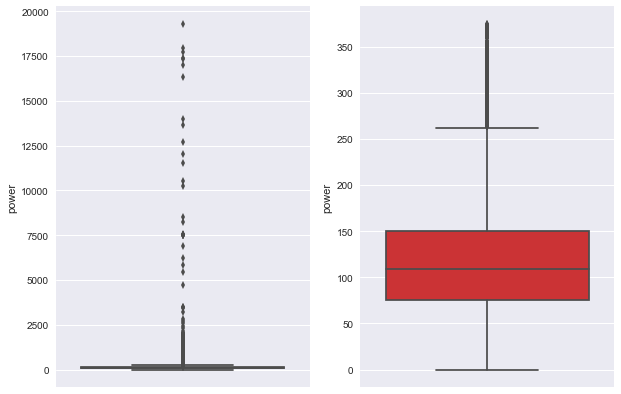

In [59]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Train_data = outliers_proc(Train_data, 'power', scale=3)

In [61]:
Train_data['kilometer'] = Train_data['kilometer'].astype('category')


In [88]:
Train_data['kilometer']

0         12.5
1         15.0
2         12.5
3         15.0
4          5.0
5         10.0
6         15.0
7         15.0
8         15.0
9         15.0
10        15.0
11         2.0
12         6.0
13        15.0
14        15.0
15        15.0
16        12.5
17        15.0
18        15.0
19        15.0
20        15.0
21        15.0
22        15.0
23        15.0
24         5.0
25        15.0
26        15.0
27        15.0
28        10.0
29        12.5
          ... 
149007    15.0
149008    15.0
149009    15.0
149010    15.0
149011    12.5
149012     6.0
149013    15.0
149014    15.0
149015    15.0
149016    12.5
149017    15.0
149018    15.0
149019    15.0
149020    12.5
149021    15.0
149022    12.5
149023    15.0
149024    12.5
149025     6.0
149026    15.0
149027     8.0
149028     5.0
149029    15.0
149030     2.0
149031     3.0
149032    15.0
149033    10.0
149034     6.0
149035    15.0
149036    12.5
Name: kilometer, Length: 149037, dtype: category
Categories (13, float64): [0.5, 1.0,

In [62]:
Train_data['model'].fillna(0,inplace=True)

In [66]:
date_cols = ['regDate', 'creatDate']

def date_proc(x):
    m = int(x[4:6])
    if m == 0:
        m = 1
    return x[:4] + '-' + str(m) + '-' + x[6:]


for f in tqdm(date_cols):
    Train_data[f] = pd.to_datetime(Train_data[f].astype('str').apply(date_proc))
    Train_data[f + '_year'] = Train_data[f].dt.year
    Train_data[f + '_month'] = Train_data[f].dt.month
    Train_data[f + '_day'] = Train_data[f].dt.day
    Train_data[f + '_dayofweek'] = Train_data[f].dt.dayofweek

100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s]


In [67]:
bin = [i*10 for i in range(61)]
Train_data['power_bin'] = pd.cut(Train_data['power'], bin, labels=False)
Train_data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [69]:
Train_data['used_time_day'] = (pd.to_datetime(Train_data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(Train_data['regDate'], format='%Y%m%d', errors='coerce')).dt.days
Train_data['used_time_month'] = round(Train_data['used_time_day'] / 30)
Train_data['used_time_year'] = round(Train_data['used_time_day'] / 365)

In [70]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'regDate_year', 'regDate_month', 'regDate_day',
       'regDate_dayofweek', 'creatDate_year', 'creatDate_month',
       'creatDate_day', 'creatDate_dayofweek', 'power_bin', 'used_time_day',
       'used_time_month', 'used_time_year'],
      dtype='object')

In [ ]:
# 截断，截断处为600
Train_data.loc[Train_data['power'] > 600,'power'] = 600

####  以上可以看出power特征，train_test分布相同，均存在异常值。需处理

In [47]:
Train_data['kilometer'].value_counts()
TestA_data['kilometer'].value_counts()

15.0    96877
12.5    15722
10.0     6459
9.0      5257
8.0      4573
7.0      4084
6.0      3725
5.0      3144
4.0      2718
3.0      2501
2.0      2354
0.5      1840
1.0       746
Name: kilometer, dtype: int64

15.0    32189
12.5     5346
10.0     2106
9.0      1791
8.0      1523
7.0      1408
6.0      1218
5.0      1093
4.0       898
3.0       849
2.0       717
0.5       616
1.0       246
Name: kilometer, dtype: int64

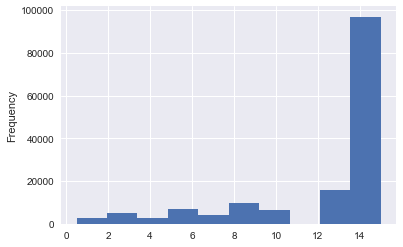

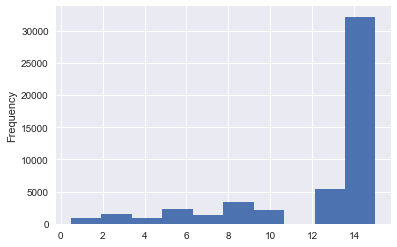

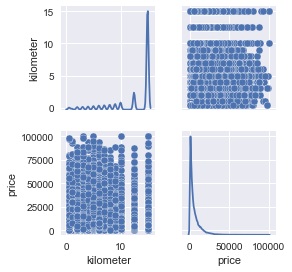

In [48]:
Train_data['kilometer'].plot.hist() 
plt.show()
TestA_data['kilometer'].plot.hist()
plt.show()

sns.set()
columns = ['kilometer', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

#### 以上看出kilometers特征已经经过处理了，分布一致

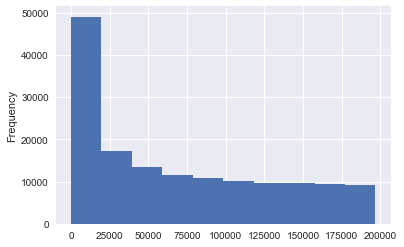

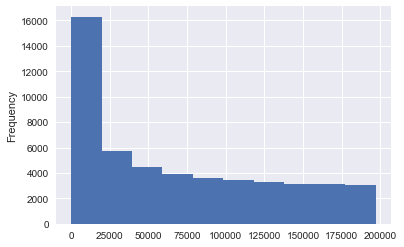

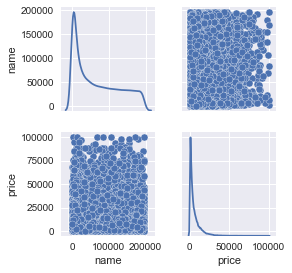

In [49]:
Train_data['name'].plot.hist() 
plt.show()
TestA_data['name'].plot.hist()
plt.show()

sns.set()
columns = ['name', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

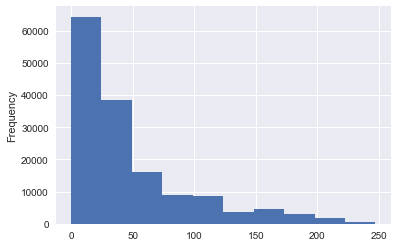

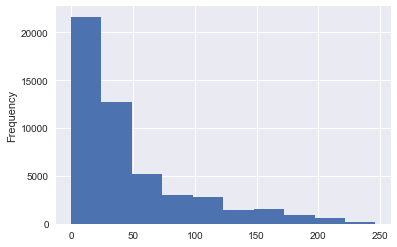

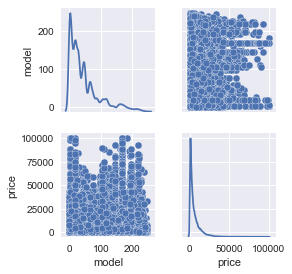

In [51]:
Train_data['model'].plot.hist() 
plt.show()
TestA_data['model'].plot.hist()
plt.show()

sns.set()
columns = ['model', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

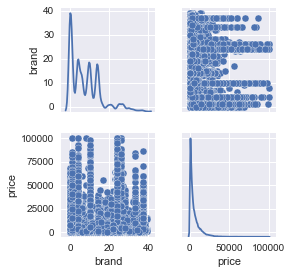

0     31480
4     16737
14    16089
10    14249
1     13794
6     10217
9      7306
5      4665
13     3817
11     2945
3      2461
7      2361
16     2223
8      2077
25     2064
27     2053
21     1547
15     1458
19     1388
20     1236
12     1109
22     1085
26      966
30      940
17      913
24      772
28      649
32      592
29      406
37      333
2       321
31      318
18      316
36      228
34      227
33      218
23      186
35      180
38       65
39        9
Name: brand, dtype: int64

0     10348
4      5763
14     5314
10     4766
1      4532
6      3502
9      2423
5      1569
13     1245
11      919
7       795
3       773
16      771
8       704
25      695
27      650
21      544
15      511
20      450
19      450
12      389
22      363
30      324
17      317
26      303
24      268
28      225
32      193
29      117
31      115
18      106
2       104
37       92
34       77
33       76
36       67
23       62
35       53
38       23
39        2
Name: brand, dtype: int64

In [56]:

sns.set()
columns = ['brand', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()


Train_data['brand'].value_counts() 
TestA_data['brand'].value_counts() 

Train Data上regionCode的统计量：
_min 0
_max: 8120
_mean 2583.0772666666667
_ptp 8120
_std 1885.356933574257
_var 3554570.766976525
Test Data上regionCode的统计量:
_min 0
_max: 8121
_mean 2590.60482
_ptp 8121
_std 1876.9514935268842
_var 3522946.909052801


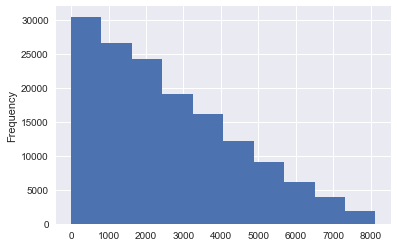

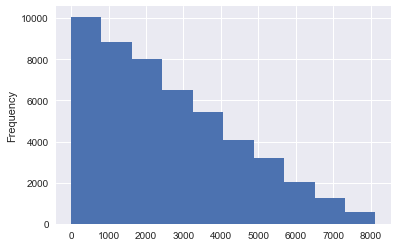

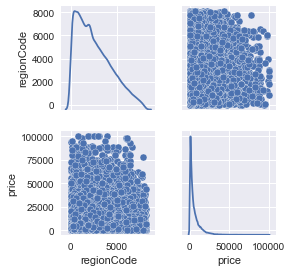

In [58]:
print('Train Data上regionCode的统计量：')
Sta_inf(Train_data['regionCode'])
print('Test Data上regionCode的统计量:')
Sta_inf(TestA_data['regionCode'])
Train_data['regionCode'].plot.hist() 
plt.show()
TestA_data['regionCode'].plot.hist()
plt.show()

sns.set()
columns = ['regionCode', 'price']
sns.pairplot(Train_data[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()


In [71]:
Train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'regDate_year', 'regDate_month', 'regDate_day',
       'regDate_dayofweek', 'creatDate_year', 'creatDate_month',
       'creatDate_day', 'creatDate_dayofweek', 'power_bin', 'used_time_day',
       'used_time_month', 'used_time_year'],
      dtype='object')

In [76]:
Train_data['notRepairedDamage'].replace('-', np.nan , inplace=True)

In [96]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
Train_data['kilometer'] = lbl.fit_transform(Train_data['kilometer'].astype(str))#将提示的包含错误数据类型这一列进行转换

In [97]:
Train_data['kilometer']

0          3
1          4
2          3
3          4
4          8
5          2
6          4
7          4
8          4
9          4
10         4
11         5
12         9
13         4
14         4
15         4
16         3
17         4
18         4
19         4
20         4
21         4
22         4
23         4
24         8
25         4
26         4
27         4
28         2
29         3
          ..
149007     4
149008     4
149009     4
149010     4
149011     3
149012     9
149013     4
149014     4
149015     4
149016     3
149017     4
149018     4
149019     4
149020     3
149021     4
149022     3
149023     4
149024     3
149025     9
149026     4
149027    11
149028     8
149029     4
149030     5
149031     6
149032     4
149033     2
149034     9
149035     4
149036     3
Name: kilometer, Length: 149037, dtype: int64

In [98]:
feature_cols = [col for col in Train_data.columns if col not in ['regDate','offerType','price','seller', 'creatDate', 'notRepairedDamage']]

feature_cols 

['SaleID',
 'name',
 'model',
 'brand',
 'bodyType',
 'fuelType',
 'gearbox',
 'power',
 'kilometer',
 'regionCode',
 'v_0',
 'v_1',
 'v_2',
 'v_3',
 'v_4',
 'v_5',
 'v_6',
 'v_7',
 'v_8',
 'v_9',
 'v_10',
 'v_11',
 'v_12',
 'v_13',
 'v_14',
 'regDate_year',
 'regDate_month',
 'regDate_day',
 'regDate_dayofweek',
 'creatDate_year',
 'creatDate_month',
 'creatDate_day',
 'creatDate_dayofweek',
 'power_bin',
 'used_time_day',
 'used_time_month',
 'used_time_year']

In [99]:
X_data = Train_data[feature_cols]
Y_data = Train_data['price']
#X_test  = TestA_data[feature_cols]

print('X train shape:',X_data.shape)
#print('X test shape:',X_test.shape)

X train shape: (149037, 37)


In [13]:
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))

In [79]:
X_data.head()

,SaleID,name,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,regDate_year,regDate_month,regDate_day,regDate_dayofweek,creatDate_year,creatDate_month,creatDate_day,creatDate_dayofweek,power_bin,used_time_day,used_time_month,used_time_year
0,0,736,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,2016-04-04,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,2004,4,2,4,2016,4,4,0,5.0,4385,146.0,12.0
1,1,2262,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,2016-03-09,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,2003,3,1,5,2016,3,9,2,NaN,4757,159.0,13.0
2,2,14874,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,2016-04-02,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,2004,4,3,5,2016,4,2,5,16.0,4382,146.0,12.0
3,3,71865,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,2016-03-12,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1996,9,8,6,2016,3,12,5,19.0,7125,238.0,20.0
4,4,111080,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,2016-03-13,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,2012,1,3,1,2016,3,13,6,6.0,1531,51.0,4.0


In [128]:
%reset?

In [127]:
xgr = xgb.LGBMRegressor(num_leaves=63,n_estimators = 100,learning_rate=0.1) 

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

AttributeError: 'GridSearchCV' object has no attribute 'LGBMRegressor'

In [120]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'

scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=120, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=120, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=120, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=120, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=120, n_jobs=0, num_parallel_tree=1,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

Train mae: 528.74591643884
Val mae 614.9345847245497


In [123]:


def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


In [107]:
x_train = Train_data[feature_cols]
y_train = Train_data['price']
x_train = x_train.fillna(-1)
y_train = y_train.fillna(-1)


In [108]:
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.3)

In [109]:
model_xgb = build_model_xgb(x_train,y_train)
model_lgb = build_model_lgb(x_train,y_train)

In [110]:
print('predict XGB...')

val_xgb = model_xgb.predict(x_val)

print('predict lgb...')

val_lgb = model_lgb.predict(x_val)


predict XGB...
predict lgb...


In [111]:
## Starking

## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)


Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred


Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb



print('第一层准备完毕！')

第一层准备完毕！


In [112]:
## level2-method 
model_lr_Stacking = build_model_lr(Strak_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print('MAE of Stacking-LR:',mean_absolute_error(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
print('MAE of Stacking-LR:',mean_absolute_error(y_val,val_pre_Stacking))

MAE of Stacking-LR: 556.6697821924259
MAE of Stacking-LR: 656.02367267945
